<a href="https://colab.research.google.com/github/arnisafazla/CS490/blob/main/CS_490_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/CS490/CS490-Senior-Research-Project

/content/drive/MyDrive/CS490/CS490-Senior-Research-Project


In [3]:
! git pull

Already up to date.


In [14]:
!git config --global user.email "arnisa.fazla@ug.bilkent.edu.tr"
!git config --global user.name "arnisafazla"

In [15]:
! git commit -m 'discriminator with projection implemented. confusion matrix updated to test equal number of classess. spatially adaptive normalization next'

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
	modified:   models/Base_WGAN.py
	modified:   models/__pycache__/Base_WGAN.cpython-37.pyc
	modified:   models/critic_models/LSTM_critic.py
	modified:   models/critic_models/__pycache__/LSTM_critic.cpython-37.pyc
	modified:   models/generator_models/__pycache__/LSTM_generator.cpython-37.pyc
	modified:   setup.ipynb
	modified:   tools.py

Untracked files:
	model.png
	models/critic_models/projection_critic.py
	projection_critic.py

no changes added to commit


In [14]:
! git check-ignore -v __pycache__/

.gitignore:1:__pycache__	__pycache__/


In [16]:
! git add .

In [15]:
! echo 'models/__pycache__/*' >> .gitignore

In [ ]:
! git add models/
! git add tools.py

In [18]:
! git push origin main

Counting objects: 17, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (17/17), done.
Writing objects: 100% (17/17), 14.34 KiB | 1.19 MiB/s, done.
Total 17 (delta 5), reused 0 (delta 0)
remote: Resolving deltas: 100% (5/5), completed with 5 local objects.
To https://github.com/arnisafazla/CS490-Senior-Research-Project.git
   0c5bc10..ebcb2a3  main -> main


In [3]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model

# path to the cloned repo
main_dir = '/content/drive/MyDrive/CS490/CS490-Senior-Research-Project'  
# path to the dataset folder
dataset_dir = '/content/drive/MyDrive/CS490/dataset'
%cd {main_dir}
sys.path.insert(0,main_dir)
from dataset import Dataset
from models.critic_models.LSTM_critic import define_critic
from models.critic_models.projection_critic import define_projection_critic
from models.generator_models.LSTM_generator import define_generator
from models.Base_WGAN import Base_WGAN

/content/drive/MyDrive/CS490/CS490-Senior-Research-Project


In [19]:
# %cd ..
# !mkdir generator_models
%cd models/critic_models
! touch projection_critic.py

/content/drive/MyDrive/CS490/CS490-Senior-Research-Project/models/critic_models


In [4]:
# path is the path to the dataset
dataset = Dataset(["anger", "joy", "fear", "neutral", "sadness", "pride"], path=dataset_dir, step_size=10, frames=200)
# dataset = Dataset(["anger"], path=dataset_dir, step_size=10, frames=400)

anger


100%|██████████| 65/65 [00:31<00:00,  2.06it/s]


joy


100%|██████████| 29/29 [00:13<00:00,  2.17it/s]


fear


100%|██████████| 32/32 [00:16<00:00,  1.99it/s]


neutral


100%|██████████| 84/84 [00:38<00:00,  2.18it/s]


sadness


100%|██████████| 46/46 [00:21<00:00,  2.10it/s]


pride


100%|██████████| 24/24 [00:11<00:00,  2.03it/s]


In [5]:
Dataset.balance(dataset)

No. of samples in each class will be:  1114


In [6]:
# save this as a separate file
config = {       # change hyperparams here
        'latent_dim' : 400,
        'in_shape' : (dataset.frames, 69),
        'n_classes' : dataset.emotions.shape[0],
        'init_std' : 0.01,
        'epochs' : 20,
        'batch_size' : 128,
        'n_critic' : 3,
        'dataset_balanced' : True,
        'critic_batch_norm' : True,
        'critic_dropout' : 0,
        'gp_weight' : 10.0      # for the gradient penalty used in critic
      }

In [7]:
critic = define_projection_critic(config)
# plot_model(critic, show_shapes=True, show_layer_names=True)
generator = define_generator(config)
# plot_model(generator, show_shapes=True, show_layer_names=True)

In [11]:
outputs_path = '/content/drive/MyDrive/CS490/models'
# the saved models, outputs, adn config files will go to this path
gan = Base_WGAN(outputs_path, 'WGAN_projection', None, critic, generator, config, dataset)

In [12]:
generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
critic_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
# Define the loss functions for the critic,
# which should be (fake_loss - real_loss).
# We will add the gradient penalty later to this loss function.
def critic_loss(real, fake):
    real_loss = tf.reduce_mean(real)
    fake_loss = tf.reduce_mean(fake)
    return fake_loss - real_loss
# Define the loss functions for the generator.
def generator_loss(fake):
    return -tf.reduce_mean(fake)

# gan = Base_WGAN('/content/drive/MyDrive/CS490/models', 'WGAN', None, critic, generator, config, dataset)

# Compile the WGAN model.
gan.compile(
    c_optimizer=critic_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    c_loss_fn=critic_loss,
)

# Start training the model.
# wgan.fit(train_images, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

In [13]:
logs_path = '/content/drive/MyDrive/CS490/logs' # path to the tensorboard logs
gan.train(logs_path)

>1, 1/52, c_loss=5.559, g_loss=0.000
>1, 2/52, c_loss=3.470, g_loss=-0.001
>1, 3/52, c_loss=1.796, g_loss=-0.002
>1, 4/52, c_loss=0.376, g_loss=-0.003
>1, 5/52, c_loss=0.100, g_loss=-0.005
>1, 6/52, c_loss=-0.027, g_loss=-0.007
>1, 7/52, c_loss=-0.008, g_loss=-0.010
>1, 8/52, c_loss=-0.110, g_loss=-0.013
>1, 9/52, c_loss=-0.027, g_loss=-0.015
>1, 10/52, c_loss=-0.126, g_loss=-0.019
>1, 11/52, c_loss=-0.057, g_loss=-0.025
>1, 12/52, c_loss=-0.144, g_loss=-0.027
>1, 13/52, c_loss=-0.127, g_loss=-0.035
>1, 14/52, c_loss=-0.196, g_loss=-0.045
>1, 15/52, c_loss=-0.209, g_loss=-0.053
>1, 16/52, c_loss=-0.227, g_loss=-0.063
>1, 17/52, c_loss=-0.263, g_loss=-0.072
>1, 18/52, c_loss=-0.138, g_loss=-0.085
>1, 19/52, c_loss=-0.309, g_loss=-0.100
>1, 20/52, c_loss=-0.213, g_loss=-0.098
>1, 21/52, c_loss=-0.283, g_loss=-0.120
>1, 22/52, c_loss=-0.339, g_loss=-0.136
>1, 23/52, c_loss=-0.360, g_loss=-0.143
>1, 24/52, c_loss=-0.310, g_loss=-0.143
>1, 25/52, c_loss=-0.192, g_loss=-0.136
>1, 26/52, c_lo

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


>2, 1/52, c_loss=-1.189, g_loss=-0.021
>2, 2/52, c_loss=-1.157, g_loss=-0.013
>2, 3/52, c_loss=-1.254, g_loss=-0.006
>2, 4/52, c_loss=-1.153, g_loss=0.001
>2, 5/52, c_loss=-0.982, g_loss=-0.046
>2, 6/52, c_loss=-1.256, g_loss=-0.037
>2, 7/52, c_loss=-1.250, g_loss=-0.050
>2, 8/52, c_loss=-1.177, g_loss=-0.066
>2, 9/52, c_loss=-1.211, g_loss=-0.059
>2, 10/52, c_loss=-1.267, g_loss=-0.100
>2, 11/52, c_loss=-1.243, g_loss=-0.063
>2, 12/52, c_loss=-1.282, g_loss=-0.081
>2, 13/52, c_loss=-1.266, g_loss=-0.052
>2, 14/52, c_loss=-1.328, g_loss=-0.090
>2, 15/52, c_loss=-1.349, g_loss=-0.100
>2, 16/52, c_loss=-1.330, g_loss=-0.062
>2, 17/52, c_loss=-1.451, g_loss=-0.065
>2, 18/52, c_loss=-1.304, g_loss=-0.082
>2, 19/52, c_loss=-1.649, g_loss=-0.053
>2, 20/52, c_loss=-1.518, g_loss=-0.055
>2, 21/52, c_loss=-1.473, g_loss=-0.038
>2, 22/52, c_loss=-1.317, g_loss=-0.072
>2, 23/52, c_loss=-1.520, g_loss=-0.048
>2, 24/52, c_loss=-1.495, g_loss=-0.037
>2, 25/52, c_loss=-1.552, g_loss=-0.062
>2, 26/52,

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


>3, 1/52, c_loss=-3.028, g_loss=-0.110
>3, 2/52, c_loss=-3.064, g_loss=-0.074
>3, 3/52, c_loss=-3.247, g_loss=-0.117
>3, 4/52, c_loss=-3.533, g_loss=-0.088
>3, 5/52, c_loss=-3.264, g_loss=-0.192
>3, 6/52, c_loss=-3.572, g_loss=-0.150
>3, 7/52, c_loss=-3.411, g_loss=-0.073
>3, 8/52, c_loss=-3.290, g_loss=-0.210
>3, 9/52, c_loss=-3.665, g_loss=-0.161
>3, 10/52, c_loss=-2.672, g_loss=-0.166
>3, 11/52, c_loss=-3.164, g_loss=-0.248
>3, 12/52, c_loss=-3.574, g_loss=-0.176
>3, 13/52, c_loss=-3.762, g_loss=-0.223
>3, 14/52, c_loss=-3.436, g_loss=-0.187


KeyboardInterrupt: ignored

In [10]:
for dir in os.listdir('/content/drive/MyDrive/CS490/models'):
  if dir[0:4] == 'WGAN' and dir != 'WGAN2022.01.26-14:29:43':
    path = os.path.join('/content/drive/MyDrive/CS490/models', dir)
    ! rm -rf $path

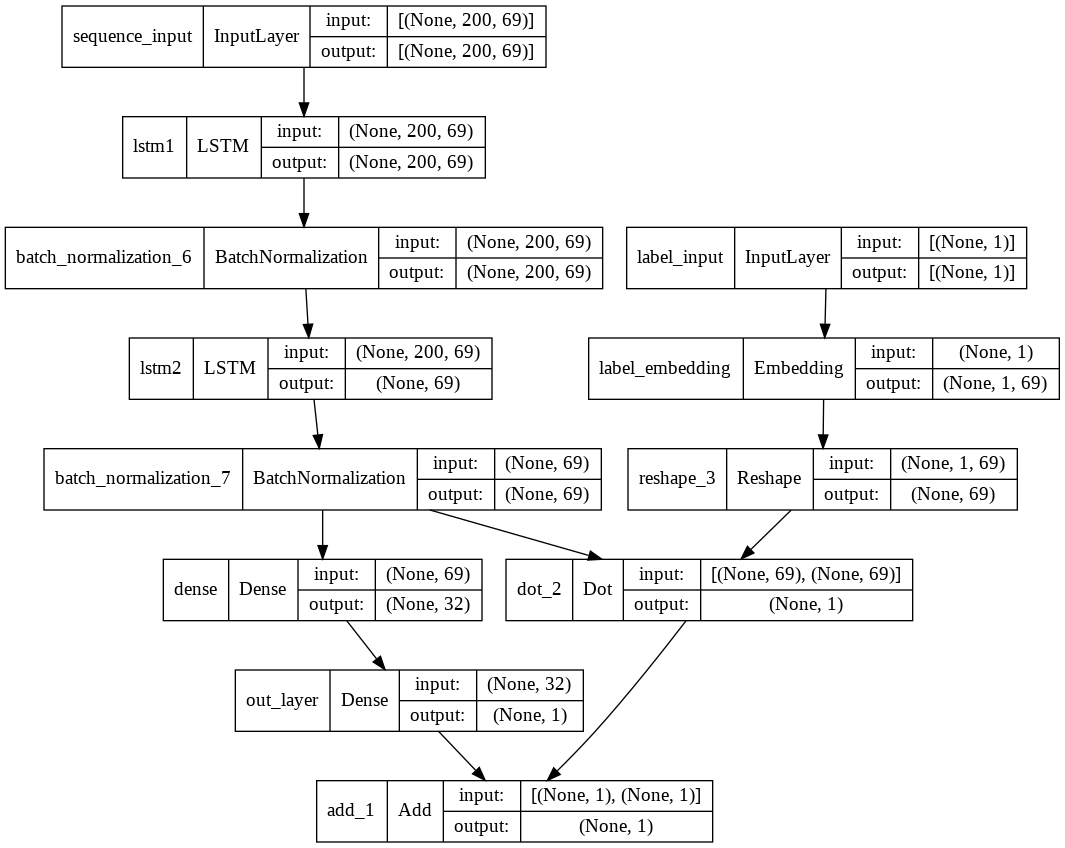

In [25]:
from keras.utils.vis_utils import plot_model
plot_model(critic, show_shapes=True, show_layer_names=True)


In [10]:
! rm -rf /content/drive/MyDrive/CS490/models/WGAN2022.01.27-14:10:21